# Train the MML model

In [1]:
%matplotlib ipympl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection._search_successive_halving import HalvingRandomSearchCV, HalvingGridSearchCV

sns.set_theme(palette='colorblind')
rs = 42

In [2]:
df_labelled = pd.read_pickle('dataset\\df_labelled_prepared_reduced.pkl')
df_unlabelled = pd.read_pickle('dataset\\df_unlabelled_prepared_reduced.pkl')

In [3]:
df_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        891 non-null    float64
 1   Fare                       891 non-null    float64
 2   SibSp                      891 non-null    int64  
 3   Parch                      891 non-null    int64  
 4   Family_num                 891 non-null    int64  
 5   Ticket_len                 891 non-null    int64  
 6   Ticket_group_size          891 non-null    int64  
 7   Sex_female                 891 non-null    float64
 8   Embarked_C                 891 non-null    float64
 9   Embarked_Q                 891 non-null    float64
 10  Embarked_S                 891 non-null    float64
 11  Age Category_adult         891 non-null    float64
 12  Age Category_child         891 non-null    float64
 13  Family_size_Medium         891 non-null    float64
 14 

In [4]:
y_labelled = df_labelled['Survived']
x_labelled = df_labelled.drop(['Survived'], axis=1)
x_unlabelled = df_unlabelled

In [5]:
model_type = 'log'
successive_halving = False

if model_type == 'log':
    param_grid = {
        "model__penalty": ["l1", "l2"],
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__solver": ["liblinear", "lbfgs"],
        "model__class_weight": [None, "balanced"],
        "model__max_iter": [1000, 1500, 2000]
    }

    if successive_halving:
        pipeline = HalvingGridSearchCV(
                    Pipeline(
                        steps=[
                        ('model', LogisticRegression())
                    ]),
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    verbose=1,
                    min_resources=256,
                )
    else:
        pipeline = GridSearchCV(
                    Pipeline(
                        steps=[
                        ('model', LogisticRegression())
                    ]),
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    verbose=1,
                )

elif model_type == "mlp":
    param_grid = {
        "model__hidden_layer_sizes": [(64, 64), (128, 64, 32), (256, 128, 64), (100, 100, 100)],
        "model__alpha": [1e-5, 1e-4, 1e-3],
        "model__learning_rate_init": [0.001, 0.01],
        "model__max_iter": [200, 400],
        "model__batch_size": [32, 64, 128]
    }

    if successive_halving:
        pipeline = HalvingGridSearchCV(
                    Pipeline(
                        steps=[
                        ('model', MLPClassifier())
                    ]),
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    verbose=1,
                    min_resources=256,
                )
    else:
        pipeline = GridSearchCV(
                    Pipeline(
                        steps=[
                        ('model', MLPClassifier())
                    ]),
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    verbose=1,
                )
        
else:
    param_grid = {
        'model__n_estimators': [500, 1000, 2000],
        'model__max_depth': [None, 20, 50],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 'log2'],
        'model__bootstrap': [True]
    }

    if successive_halving:
        pipeline = HalvingGridSearchCV(
                    Pipeline(
                        steps=[
                        ('model', RandomForestClassifier(n_jobs=-1))
                    ]),
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    verbose=1,
                    min_resources=256,
                )
    else:
        pipeline = GridSearchCV(
                    Pipeline(
                        steps=[
                        ('model', RandomForestClassifier(n_jobs=-1))
                    ]),
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    verbose=1,
                )

In [6]:
# split the labelled set into train_val and test set
x_trainval, x_test, y_trainval, y_test = train_test_split(x_labelled, y_labelled, train_size=0.85, random_state=rs, stratify=y_labelled)

# predict the labelled outcome
pipeline.fit(x_trainval, y_trainval)
y_pred = pipeline.predict(x_test)

# predict probabilities
y_scores = pipeline.predict_proba(x_test)
# keep probabilities for the positive outcome only
y_scores = y_scores[:, 1]

Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\bruno\Desktop\AI\DS Projects\Titanic\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\bruno\Desktop\AI\DS Projects\Titanic\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-

In [7]:
def plot_classification_report(y_test, y_pred):
    c_report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    return c_report

c_report_dict = plot_classification_report(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87        83
         1.0       0.80      0.73      0.76        51

    accuracy                           0.83       134
   macro avg       0.82      0.81      0.81       134
weighted avg       0.83      0.83      0.83       134



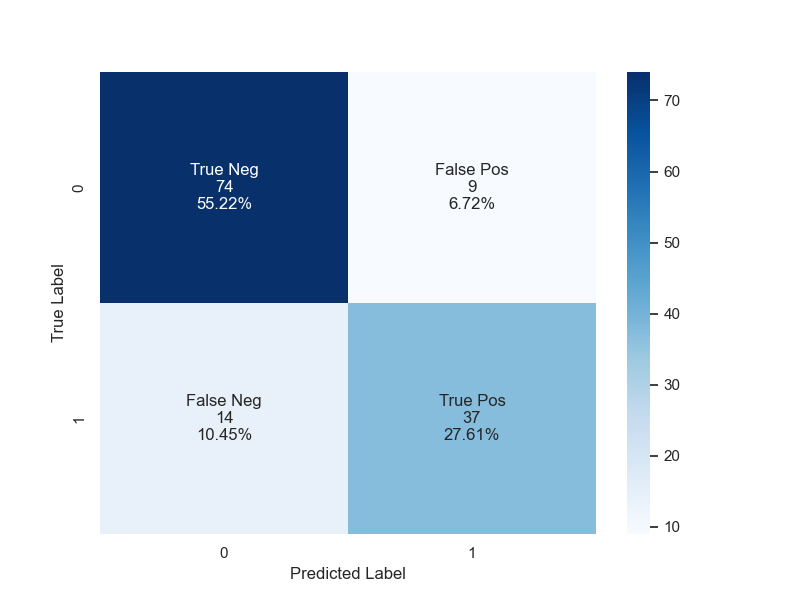

In [8]:
def plot_conf_matrix(y_test, y_pred):
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix(y_test, y_pred).flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix(y_test, y_pred).flatten()/np.sum(confusion_matrix(y_test, y_pred))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt="", cmap='Blues', ax=ax)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_conf_matrix(y_test, y_pred)

Area Under ROC AUC: 0.838


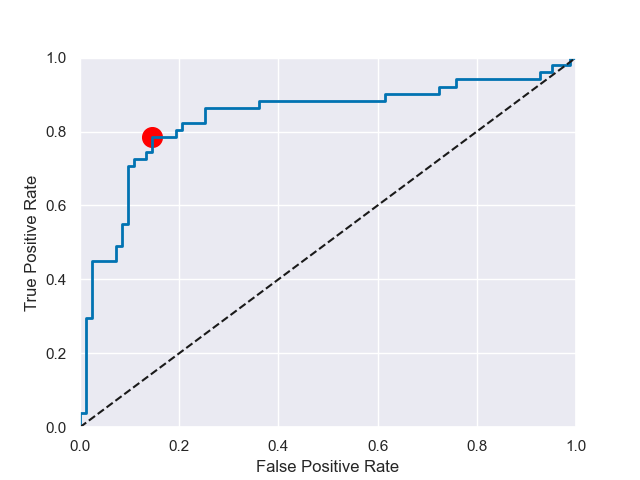

In [9]:
def plot_roc_curve(y_test, y_scores):
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    roc_auc = round(roc_auc_score(y_test, y_scores), 3)
    print('Area Under ROC AUC: %.3f' % (roc_auc))
    
    optimal_idx = np.argmax(tpr - fpr)

    fig3, ax3 = plt.subplots()
    ax3.plot(fpr, tpr, linewidth=2)
    ax3.plot([0,1], [0,1], 'k--')
    ax3.axis((0,1,0,1))
    ax3.scatter(fpr[optimal_idx], tpr[optimal_idx], 200, marker='o', color='red', label='Best')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    plt.show()
    
    return roc_auc

roc_auc = plot_roc_curve(y_test, y_scores)

Highest F1-Score: 0.77670
Threshold F1-Score: 0.436
Precision for Highest F1-Score: 0.77
Recall for Highest F1-Score: 0.78


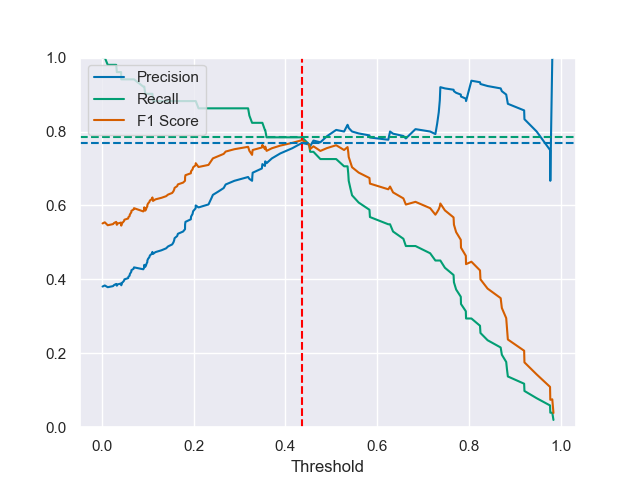

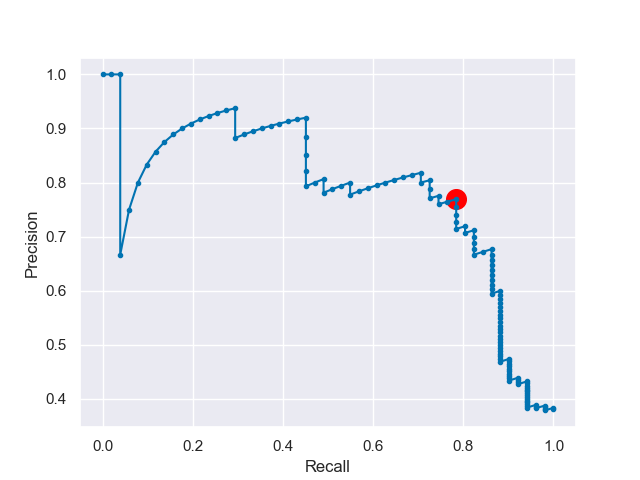

In [10]:
def plot_precision_recall_vs_threshold(y_test, y_scores):
    
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # convert to f score
    fscore = (2 * precisions * recalls) / (precisions + recalls)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    print("Highest F1-Score: %.5f" % fscore[ix])
    print("Threshold F1-Score: %.3f" % thresholds[ix])
    print("Precision for Highest F1-Score: %.2f" % precisions[ix])
    print("Recall for Highest F1-Score: %.2f" % recalls[ix])

    fig1, ax1 = plt.subplots()
    ax1.plot(thresholds, precisions[:-1], "b", label="Precision")
    ax1.plot(thresholds, recalls[:-1], "g", label="Recall")
    ax1.plot(thresholds, fscore[:-1], "r", label="F1 Score")
    ax1.axvline(x=thresholds[ix], color='red', linestyle='--')
    plt.axhline(y=precisions[ix], color='b', linestyle='--')
    plt.axhline(y=recalls[ix], color='g', linestyle='--')
    ax1.set_xlabel("Threshold")
    ax1.legend(loc="upper left")
    ax1.set_ylim((0,1))
    plt.show()

    fig2, ax2 = plt.subplots()
    ax2.plot(recalls, precisions, marker='.', label='Logistic')
    ax2.scatter(recalls[ix], precisions[ix], 200, marker='o', color='red', label='Best')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    plt.show()

plot_precision_recall_vs_threshold(y_test, y_scores)

In [79]:
def create_sumbission(clf, x_labelled, y_labelled, x_unlabelled, i):
    # predict the unlabelled values with the labelled classification model
    clf.fit(x_labelled, y_labelled)
    y_pred = clf.predict(x_unlabelled).astype(int)
    
    df_submission = pd.read_csv("dataset/gender_submission.csv")
    df_submission['Survived'] = y_pred
    df_submission.to_csv(f"submissions\\submission_{i}.csv", index=False)

In [67]:
create_sumbission(pipeline.best_estimator_, x_labelled, y_labelled, x_unlabelled, f"{model_type}_sh_{successive_halving}")